In [1]:
import csv
import datetime
import h5py
import itertools
import keras
import numpy as np
import os
import pandas as pd
import pescador
import random
import sys
import tensorflow as tf
import time

sys.path.append("../src")
import localmodule

Using TensorFlow backend.


In [3]:
# Define constants.
dataset_name = localmodule.get_dataset_name()
folds = localmodule.fold_units()
models_dir = localmodule.get_models_dir()
n_input_hops = 104
n_filters = [24, 48, 48]
kernel_size = [5, 5]
pool_size = [2, 4]
n_hidden_units = 64
steps_per_epoch = 1
epochs = 128
validation_steps = 1
batch_size = 32


# Read command-line arguments.
args = ["all", "unit01", "trial-9"]
aug_kind_str = args[0]
unit_str = args[1]
trial_str = args[2]


# Retrieve fold such that unit_str is in the test set.
fold = [f for f in folds if unit_str in f[0]][0]
test_units = fold[0]
training_units = fold[1]
validation_units = fold[2]


# Print header.
start_time = int(time.time())
print(str(datetime.datetime.now()) + " Start.")
print("Training Salamon's ICASSP 2017 convnet on " + dataset_name + ". ")
print("Training set: " + ", ".join(training_units) + ".")
print("Validation set: " + ", ".join(validation_units) + ".")
print("Test set: " + ", ".join(test_units) + ".")
print("")
print('h5py version: {:s}'.format(h5py.__version__))
print('keras version: {:s}'.format(keras.__version__))
print('numpy version: {:s}'.format(np.__version__))
print('pandas version: {:s}'.format(pd.__version__))
print('pescador version: {:s}'.format(pescador.__version__))
print('tensorflow version: {:s}'.format(tf.__version__))
print("")


# Define and compile Keras model.
# NB: the original implementation of Justin Salamon in ICASSP 2017 relies on
# glorot_uniform initialization for all layers, and the optimizer is a
# stochastic gradient descent (SGD) with a fixed learning rate of 0.1.
# Instead, we use a he_uniform initialization for the layers followed
# by rectified linear units (see He ICCV 2015), and replace the SGD by
# the Adam adaptive stochastic optimizer (see Kingma ICLR 2014).

# Input
inputs = keras.layers.Input(shape=(128, n_input_hops, 1))

# Layer 1
bn = keras.layers.normalization.BatchNormalization()(inputs)
conv1 = keras.layers.Convolution2D(n_filters[0], kernel_size,
    padding="same", kernel_initializer="he_normal")(bn)
pool1 = keras.layers.MaxPooling2D(pool_size=pool_size)(conv1)

# Layer 2
conv2 = keras.layers.Convolution2D(n_filters[1], kernel_size,
    padding="same", kernel_initializer="he_normal", activation="relu")(pool1)
pool2 = keras.layers.MaxPooling2D(pool_size=pool_size)(conv2)

# Layer 3
conv3 = keras.layers.Convolution2D(n_filters[2], kernel_size,
    padding="same", kernel_initializer="he_normal", activation="relu")(pool2)

# Layer 4
flatten = keras.layers.Flatten()(conv3)
dense1 = keras.layers.Dense(n_hidden_units,
    kernel_initializer="he_normal", activation="relu",
    kernel_regularizer=keras.regularizers.l2(0.001))(flatten)

# Layer 5
# We put a single output instead of 43 in the original paper, because this
# is binary classification instead of multilabel classification.
# Furthermore, this layer contains 43 times less connections than in the
# original paper, so we divide the l2 weight penalization by 50, which is
# of the same order of magnitude as 43.
# 0.001 / 50 = 0.00002
dense2 = keras.layers.Dense(1,
    kernel_initializer="normal", activation="sigmoid",
    kernel_regularizer=keras.regularizers.l2(0.00002))(dense1)


# Compile model, print model summary.
model = keras.models.Model(inputs=inputs, outputs=dense2)
model.compile(loss="binary_crossentropy",
    optimizer="adam", metrics=["accuracy"])
model.summary()


# Build Pescador streamers corresponding to log-mel-spectrograms in augmented
# training set.
training_streamer = localmodule.multiplex_logmelspec(
    aug_kind_str, training_units, n_input_hops, batch_size)

2017-08-24 15:32:40.570586 Start.
Training Salamon's ICASSP 2017 convnet on BirdVox-70k. 
Training set: unit02, unit03, unit05.
Validation set: unit07, unit10.
Test set: unit01.

h5py version: 2.6.0
keras version: 2.0.6
numpy version: 1.13.1
pandas version: 0.20.3
pescador version: 1.0.0
tensorflow version: 1.2.1

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 104, 1)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 104, 1)       4         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 104, 24)      624       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 26, 24)        0         
_________________________________________________________________
conv2d_2 (Conv2D)       

In [3]:
# none
history = model.fit_generator(
    training_streamer,
    steps_per_epoch = 1024,
    epochs = 1,
    verbose = True)

Epoch 1/1
1024/1024 [==============================] - 1091s - loss: 3.9459 - acc: 0.5600     

In [4]:
history = model.fit_generator(
    training_streamer,
    steps_per_epoch = 32,
    epochs = 32,
    verbose = True)

Epoch 1/32
32/32 [==============================] - 72s - loss: 0.8826 - acc: 0.5283      

In [11]:
Xy = next(training_streamer)
X, y = Xy[0], Xy[1]
np.set_printoptions(suppress=True, precision=10)
print(np.stack((model.predict(X), y)).T)
print(model.evaluate(X, y))

[[[ 0.4850092828  1.          ]
  [ 0.4850092828  1.          ]
  [ 0.4850092828  0.          ]
  [ 0.4850092828  1.          ]
  [ 0.4850092828  0.          ]
  [ 0.9999427795  1.          ]
  [ 0.4850092828  0.          ]
  [ 0.4850092828  0.          ]
  [ 0.9513843656  1.          ]
  [ 0.4850092828  1.          ]
  [ 0.4850092828  1.          ]
  [ 0.4850092828  0.          ]
  [ 0.4850092828  1.          ]
  [ 0.4850092828  0.          ]
  [ 0.4850092828  0.          ]
  [ 0.4850092828  1.          ]
  [ 0.4850092828  0.          ]
  [ 0.4850092828  0.          ]
  [ 0.4850092828  0.          ]
  [ 0.4850092828  1.          ]
  [ 0.6434298754  1.          ]
  [ 0.4850092828  1.          ]
  [ 0.4850092828  1.          ]
  [ 0.4850092828  0.          ]
  [ 0.9844681621  1.          ]
  [ 0.4850092828  0.          ]
  [ 0.4850092828  1.          ]
  [ 0.4850092828  0.          ]
  [ 0.4850092828  0.          ]
  [ 0.4850092828  0.          ]
  [ 0.4850092828  1.          ]
  [ 0.48

(array([ 3.,  5.,  7.,  4.,  1.,  3.,  5.,  0.,  1.,  3.]),
 array([-32.8951377869, -32.4277366638, -31.9603355408, -31.4929344177,
        -31.0255332947, -30.5581321716, -30.0907310486, -29.6233299255,
        -29.1559288025, -28.6885276794, -28.2211265564]),
 <a list of 10 Patch objects>)

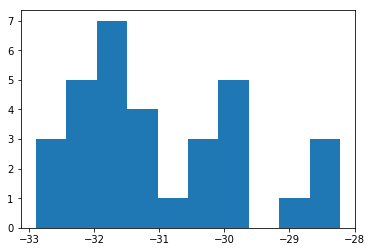

In [79]:
%matplotlib inline
from matplotlib import pyplot as plt

X = next(training_streamer)

plt.hist(np.mean(X[0], axis=(1, 2, 3)))

(array([  9.,  18.,  20.,  24.,  45.,  28.,  34.,  34.,  30.,  14.]),
 array([-33.9532814026, -33.0907934189, -32.2283054352, -31.3658174515,
        -30.5033294678, -29.6408414841, -28.7783535004, -27.9158655167,
        -27.053377533 , -26.1908895493, -25.3284015656]),
 <a list of 10 Patch objects>)

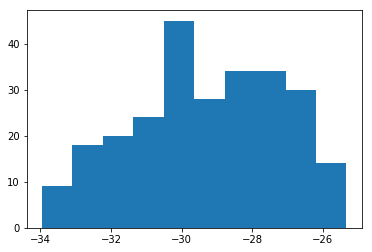

In [80]:
%matplotlib inline
from matplotlib import pyplot as plt

X = next(noise_streamer)

plt.hist(np.mean(X[0] - 18, axis=(1, 2, 3)))

In [11]:
# Parse augmentation kind string (aug_kind_str).
fold_units = localmodule.get_units()
n_hops = 192
augs = ["original"]
lms_paths = []

# Generate a Pescador streamer for every HDF5 container, that is,
# every unit-augmentation-instance triplet.
aug_dict = localmodule.get_augmentations()
data_dir = localmodule.get_data_dir()
dataset_name = localmodule.get_dataset_name()
logmelspec_name = "_".join([dataset_name, "logmelspec"])
logmelspec_dir = os.path.join(data_dir, logmelspec_name)
streams = []
for aug_str in augs:
    aug_dir = os.path.join(logmelspec_dir, aug_str)
    if aug_str == "original":
        instances = [aug_str]
    else:
        n_instances = aug_dict[aug_str]
        instances = ["-".join([aug_str, str(instance_id)])
            for instance_id in range(n_instances)]
    for instanced_aug_str in instances:
        for unit_str in fold_units:
            lms_name = "_".join([dataset_name, instanced_aug_str, unit_str])
            lms_path = os.path.join(aug_dir, lms_name + ".hdf5")
            lms_paths.append(lms_path)
            stream = pescador.Streamer(localmodule.yield_logmelspec, lms_path, n_hops)
            streams.append(stream)

In [13]:
import tqdm
lms_means = []
for lms_path in tqdm.tqdm(lms_paths):
    f = h5py.File(lms_path)
    for key in list(f["logmelspec"].keys()):
        lms_mean = np.mean(f["logmelspec"][key])
        lms_means.append(lms_mean)

100%|██████████| 6/6 [00:35<00:00,  6.06s/it]


(array([  5.80000000e+01,   7.34000000e+02,   2.73600000e+03,
          2.39360000e+04,   1.88423000e+05,   4.62761000e+05,
          4.64678000e+05,   4.68722000e+05,   8.71120000e+04,
          1.36000000e+02]),
 array([-23.09432411, -21.2279676 , -19.36161108, -17.49525456,
        -15.62889805, -13.76254153, -11.89618502, -10.0298285 ,
         -8.16347198,  -6.29711547,  -4.43075895]),
 <a list of 10 Patch objects>)

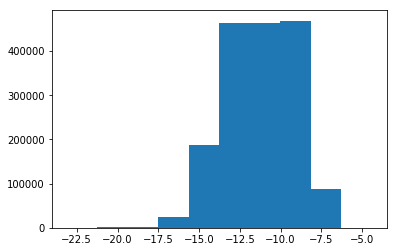

In [10]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.hist(noisy_means)

(array([  4.50640000e+04,   1.60370000e+04,   2.30900000e+03,
          3.59800000e+03,   3.61200000e+03,   9.40000000e+01,
          7.30000000e+01,   1.30000000e+01,   2.00000000e+00,
          2.00000000e+00]),
 array([-31.09420013, -28.45017886, -25.80615759, -23.16213632,
        -20.51811504, -17.87409377, -15.2300725 , -12.58605123,
         -9.94202995,  -7.29800868,  -4.65398741]),
 <a list of 10 Patch objects>)

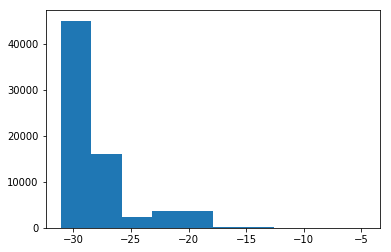

In [15]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.hist(original_means)

In [21]:
np.mean(noisy_means) - np.mean(original_means)

16.673203